<a href="https://colab.research.google.com/github/abazabaaa/colab_tutorial/blob/main/compare_etic_bound_minimized_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
chmod +x Miniconda3-latest-Linux-x86_64.sh
./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
conda config --set always_yes yes --set changeps1 no
conda install -q -y -c conda-forge python=3.7
conda install -q -y -c conda-forge rdkit==2020.09.2
 

In [2]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem

In [3]:
! conda config --add channels omnia --add channels conda-forge
! conda install -y openforcefield
!pip install py3Dmol
!pip install --upgrade http://github.com/biomadeira/pyPDBeREST/zipball/master

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - openforcefield


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ambertools-18.0            |                0       114.9 MB  omnia
    argon2-cffi-20.1.0         |   py37h4abf009_2          47 KB  conda-forge
    async_generator-1.10       |             py_0          18 KB  conda-forge
    attrs-20.3.0               |     pyhd3deb0d_0          41 KB  conda-forge
    backcall-0.2.0             |     pyh9f0ad1d_0          13 KB  conda-forge
    backp

In [4]:
from rdkit import rdBase
print(rdBase.rdkitVersion)

2020.09.1


In [5]:
!wget https://raw.githubusercontent.com/openforcefield/openff-forcefields/7300a486581feff508b9401241443f941924783f/openforcefields/offxml/openff-1.0.0.offxml
!conda install -c conda-forge prody

--2021-03-19 13:42:55--  https://raw.githubusercontent.com/openforcefield/openff-forcefields/7300a486581feff508b9401241443f941924783f/openforcefields/offxml/openff-1.0.0.offxml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62154 (61K) [text/plain]
Saving to: ‘openff-1.0.0.offxml’

openff-1.0.0.offxml 100%[===================>]  60.70K  --.-KB/s    in 0.004s  

2021-03-19 13:42:56 (15.6 MB/s) - ‘openff-1.0.0.offxml’ saved [62154/62154]

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \

In [18]:
import sys
from prody import *
from rdkit import Chem
from rdkit.Chem import AllChem
from io import StringIO
from collections import defaultdict
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDistGeom
from rdkit.Chem import rdMolAlign
IPythonConsole.ipython_3d = True
import py3Dmol
from openforcefield.topology import Molecule
from openforcefield.topology import Topology
from openforcefield.utils import RDKitToolkitWrapper
from openforcefield.typing.engines.smirnoff import ForceField
from simtk import openmm
from simtk import unit
from rdkit.Chem import rdMolAlign
import numpy as np
from simtk import openmm, unit
import json
from pdbe import pyPDBeREST

def drawit(m,p=None,confId=-1):
        mb = Chem.MolToMolBlock(m,confId=confId)
        if p is None:
            p = py3Dmol.view(width=400,height=400)
        p.removeAllModels()
        p.addModel(mb,'sdf')
        p.setStyle({'stick':{}})
        p.setBackgroundColor('0xeeeeee')
        p.zoomTo()
        return p.show()

def make_confsfrom3dmol(single3dmol):
    mol = single3dmol
    refmol = Chem.AddHs(Chem.Mol(mol))
    param = rdDistGeom.ETKDGv2()
    param.pruneRmsThresh = 0.1
    cids = rdDistGeom.EmbedMultipleConfs(mol, 10, param)
    mp = AllChem.MMFFGetMoleculeProperties(mol, mmffVariant='MMFF94s')
    AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=0, mmffVariant='MMFF94s')
    sdfpath = 'etic_confs.sdf'
    w = Chem.SDWriter(sdfpath)
    res = []
    for cid in cids:
      ff = AllChem.MMFFGetMoleculeForceField(mol, mp, confId=cid)
      e = ff.CalcEnergy()
      res.append((cid, e))
    sorted_res = sorted(res, key=lambda x:x[1])
    rdMolAlign.AlignMolConformers(mol)
    for cid, e in sorted_res:
        mol.SetProp('CID', str(cid))
        mol.SetProp('Energy', str(e))
        w.write(mol, confId=cid)
    w.close()
    return sdfpath

def get_3pdl_ligand():
    ag = parsePDB('3pbl')
    etq = ag.resname_ETQ
    output = StringIO()
    writePDBStream(output, etq)
    pdb_string = output.getvalue()
    rd_mol = AllChem.MolFromPDBBlock(pdb_string)
    ligand_data = fetchPDBLigand('ETQ')
    template = AllChem.MolFromSmiles(ligand_data['OpenEye_OEToolkits_SMILES_CANONICAL'])
    rs = Chem.GetMolFrags(rd_mol,asMols=True)
    newMol = AllChem.AssignBondOrdersFromTemplate(template, rs[0])
    newerMol = AllChem.AddHs(newMol, addCoords=True)
    return newerMol
  

def get_bound_ligand_from_pdb(pdb_id):
    # get information associated with molecules from PDBe
    p = pyPDBeREST()
    molecule_info = p.PDB.getMolecules(pdbid=pdb_id)
    
    #get the pdb in a way similar to Pat's post
    ag = parsePDB(pdb_id)
    
    #load the json into python from PDBe
    compound_dict = json.loads(molecule_info)
    
    #use list comprehension to deal with the compounds in the json
    compounds = [compound_dict[pdb_id][l] for l in range(len(compound_dict[pdb_id]))]

    # create a dictionary with key pairs and use them to get ligand name and ligand_code for extraction
    # with prody. Loop of the list above and get the info
    Dict = {}
    Dict['molecule_name'] = {}
    for entries in compounds:    
        if entries['molecule_type'] == 'bound':
            ligand_name = entries['molecule_name'][0]
            ligand_code = entries['chem_comp_ids'][0]
            ligand_chain_associations = entries['in_chains'][0]
            Dict['molecule_name'][ligand_name] = {'chem_comp_ids':ligand_code}
    ## use list comprehension to unwrap the compound names
    compound_names = [k for k in Dict['molecule_name']]
    
    ## create a new dictionary for RDKIT mol objects we might find.
    extracted_ligands = {}
    extracted_ligands['ligand_code'] = {}
    
    ##Now, lets loop over the compound_names list and use count/enumerate to unwrap 
    # ligand codes one by one and then pass them into our function
    for count,compound in enumerate(compound_names):
        ligand_code = Dict['molecule_name'][compound_names[count]]['chem_comp_ids']
        
        #get the info associated with the bound ligand and return the SMILES
        ligand_data = fetchPDBLigand(ligand_code)
        template = AllChem.MolFromSmiles(ligand_data['OpenEye_OEToolkits_SMILES_CANONICAL'])

        #now we need the prody command to pull the ligand
        arg = 'resname_{ligand_code}'.format(ligand_code = ligand_code)

        #use getattr to pass in arg the allow us to select the ligand in the pdb
        ligand = getattr(ag, arg)

        #use stringIO to collect the pdb information for the ligand
        output = StringIO()
        writePDBStream(output, ligand)
        pdb_string = output.getvalue()

        #make an RDKit mol
        rd_mol = AllChem.MolFromPDBBlock(pdb_string)
        
        #now we use our logic from before, but this time we put the rdkit mol objects
        #into a dictionary
        
        if len(AllChem.GetMolFrags(rd_mol)) == 1:
            mol_w_bond_orders = AllChem.AssignBondOrdersFromTemplate(template, rd_mol)
            mol = AllChem.AddHs(mol_w_bond_orders, addCoords=True)
            extracted_ligands['ligand_code'][ligand_code] = {'rdkmol_obj':mol}
        else:
            split_structures = Chem.GetMolFrags(rd_mol,asMols=True)
            if template.GetNumAtoms() == split_structures[0].GetNumAtoms():
                mol_w_bond_orders = AllChem.AssignBondOrdersFromTemplate(template, split_structures[0])
                mol = AllChem.AddHs(mol_w_bond_orders, addCoords=True)
                extracted_ligands['ligand_code'][ligand_code] = {'rdkmol_obj':mol}
            else:
#                 raise ValueError()
                print(f'template and identified mol object from {pdb_id} do not have the same number of atoms')
                pass

    return extracted_ligands

# def minimize_multiconf_sdf(sdf_path):
#   rdktkw = RDKitToolkitWrapper()

#   # Load in the molecule and its conformers.
#   # Note that all conformers of the same molecule are loaded as separate Molecule objects
#   loaded_molecules = Molecule.from_file(sdf_path, toolkit_registry=rdktkw)

#   # The logic below only works for lists of molecules, so if a
#   # single molecule was loaded, cast it to list
#   if type(loaded_molecules) is not list:
#       loaded_molecules = [loaded_molecules]

#   # Collatate all conformers of the same molecule
#   # NOTE: This isn't necessary if you have already loaded or created multi-conformer molecules;
#   # it is just needed because our SDF reader does not automatically collapse conformers.
#   molecules = [loaded_molecules[0]]
#   for molecule in loaded_molecules[1:]:
#       if molecule == molecules[-1]:
#           for conformer in molecule.conformers:
#               molecules[-1].add_conformer(conformer)
#       else:
#           molecules.append(molecule)

#   n_molecules = len(molecules)
#   n_conformers = sum([mol.n_conformers for mol in molecules])
#   print(f'{n_molecules} unique molecule(s) loaded, with {n_conformers} total conformers')
#   forcefield = ForceField('openff-1.0.0.offxml')
#   for molecule in molecules:
#       # If the molecule doesn't have a name, set mol.name to be the hill formula
#       if molecule.name == '':
#           molecule.name = Topology._networkx_to_hill_formula(molecule.to_networkx())
#       print('%s : %d conformers' % (molecule.name, molecule.n_conformers))
#       # Make a temporary copy of the molecule that we can update for each minimization
#       mol_copy = Molecule(molecule)
#       # Make an OpenFF Topology so we can parameterize the system
#       off_top = molecule.to_topology()
#       print(f"Parametrizing {molecule.name} (may take a moment to calculate charges)")
#       system = forcefield.create_openmm_system(off_top)
#       # Use OpenMM to compute initial and minimized energy for all conformers
#       integrator = openmm.VerletIntegrator(1*unit.femtoseconds)
#       platform = openmm.Platform.getPlatformByName('Reference')
#       omm_top = off_top.to_openmm()
#       simulation = openmm.app.Simulation(omm_top, system, integrator, platform)
      
#       # Print text header
#       print('Conformer         Initial PE        Minimized PE        RMS between initial and minimized conformer')
#       output = [['Conformer','Initial PE (kcal/mol)','Minimized PE (kcal/mol)','RMS between initial and minimized conformer (Angstrom)']]
#       for conformer_index, conformer in enumerate(molecule.conformers):
#           simulation.context.setPositions(conformer)
#           orig_potential = simulation.context.getState(getEnergy=True).getPotentialEnergy()
#           simulation.minimizeEnergy()
#           min_state = simulation.context.getState(getEnergy=True, getPositions=True)
#           min_potential = min_state.getPotentialEnergy()
          
#           # Calculate the RMSD between the initial and minimized conformer
#           min_coords = min_state.getPositions()
#           min_coords = np.array([ [atom.x, atom.y, atom.z] for atom in min_coords]) * unit.nanometer
#           mol_copy._conformers = None
#           mol_copy.add_conformer(conformer)
#           mol_copy.add_conformer(min_coords)
#           rdmol = mol_copy.to_rdkit()
#           rmslist = []
#           rdMolAlign.AlignMolConformers(rdmol, RMSlist=rmslist)
#           minimization_rms = rmslist[0]

#           # Save the minimized conformer to file
#           mol_copy._conformers = None
#           mol_copy.add_conformer(min_coords)
#           mol_copy.to_file(f'{molecule.name}_conf{conformer_index+1}_minimized.sdf', file_format='sdf')
#           print('%5d / %5d : %8.3f kcal/mol %8.3f kcal/mol  %8.3f Angstroms' % (conformer_index+1, molecule.n_conformers, orig_potential/unit.kilocalories_per_mole, min_potential/unit.kilocalories_per_mole, minimization_rms))
#           output.append([str(conformer_index+1), 
#                         f'{orig_potential/unit.kilocalories_per_mole:.3f}', 
#                         f'{min_potential/unit.kilocalories_per_mole:.3f}', 
#                         f'{minimization_rms:.3f}'])
#       # Write the results out to CSV
#       with open(f'{molecule.name}.csv', 'w') as of:
#           for line in output:
#               of.write(','.join(line)+'\n')
#       # Clean up OpenMM Simulation
#       del simulation, integrator

# def minimize_single_molecule(single3dmol):
#     rdktkw = RDKitToolkitWrapper()
#     loaded_molecules = rdktkw.from_rdkit(single3dmol)
#     if type(loaded_molecules) is not list:
#       loaded_molecules = [loaded_molecules]
        
#     molecules = [loaded_molecules[0]]
#     for molecule in loaded_molecules[1:]:
#       if molecule == molecules[-1]:
#         for conformer in molecule.conformers:
#           molecules[-1].add_conformer(conformer)
#       else:
#         molecules.append(molecule)

#     n_molecules = len(molecules)
#     n_conformers = sum([mol.n_conformers for mol in molecules])
#     print(f'{n_molecules} unique molecule(s) loaded, with {n_conformers} total conformers')
#     forcefield = ForceField('/content/openff-1.0.0.offxml')
#     for molecule in molecules:
#         # If the molecule doesn't have a name, set mol.name to be the hill formula
#         if molecule.name == '':
#             molecule.name = Topology._networkx_to_hill_formula(molecule.to_networkx())
#             print('%s : %d conformers' % (molecule.name, molecule.n_conformers))
#             # Make a temporary copy of the molecule that we can update for each minimization
#         mol_copy = Molecule(molecule)
#         # Make an OpenFF Topology so we can parameterize the system
#         off_top = molecule.to_topology()
#         print(f"Parametrizing {molecule.name} (may take a moment to calculate charges)")
#         system = forcefield.create_openmm_system(off_top)
#         # Use OpenMM to compute initial and minimized energy for all conformers
#         integrator = openmm.VerletIntegrator(1*unit.femtoseconds)
#         platform = openmm.Platform.getPlatformByName('Reference')
#         omm_top = off_top.to_openmm()
#         simulation = openmm.app.Simulation(omm_top, system, integrator, platform)

#         # Print text header
#         print('Conformer         Initial PE         Minimized PE       RMS between initial and minimized conformer')
#         output = [['Conformer','Initial PE (kcal/mol)','Minimized PE (kcal/mol)','RMS between initial and minimized conformer (Angstrom)']]
#         for conformer_index, conformer in enumerate(molecule.conformers):
#             simulation.context.setPositions(conformer)
#             orig_potential = simulation.context.getState(getEnergy=True).getPotentialEnergy()
#             simulation.minimizeEnergy()
#             min_state = simulation.context.getState(getEnergy=True, getPositions=True)
#             min_potential = min_state.getPotentialEnergy()

#             # Calculate the RMSD between the initial and minimized conformer
#             min_coords = min_state.getPositions()
#             min_coords = np.array([ [atom.x, atom.y, atom.z] for atom in min_coords]) * unit.nanometer
#             mol_copy._conformers = None
#             mol_copy.add_conformer(conformer)
#             mol_copy.add_conformer(min_coords)
#             rdmol = mol_copy.to_rdkit()
#             rmslist = []
#             rdMolAlign.AlignMolConformers(rdmol, RMSlist=rmslist)
#             minimization_rms = rmslist[0]

#             # Save the minimized conformer to file
#             mol_copy._conformers = None
#             mol_copy.add_conformer(min_coords)
#             mol_copy.to_file(f'minimized_etic_conf{conformer_index+1}_minimized.sdf', file_format='sdf')
#             print('%5d / %5d : %8.3f kcal/mol %8.3f kcal/mol  %8.3f Angstroms' % (conformer_index+1, molecule.n_conformers, orig_potential/unit.kilocalories_per_mole, min_potential/unit.kilocalories_per_mole, minimization_rms))
#             output.append([str(conformer_index+1), 
#                            f'{orig_potential/unit.kilocalories_per_mole:.3f}', 
#                            f'{min_potential/unit.kilocalories_per_mole:.3f}', 
#                            f'{minimization_rms:.3f}'])

# def compare_minimized_structure(eticlopride_active_conf, sdf_path):
#   suppl = Chem.SDMolSupplier(sdf_path)
#   minimized_mol = AllChem.AddHs(suppl[0], addCoords=True)

#   AllChem.AlignMol(minimized_mol,eticlopride_active_conf)
#   mb = Chem.MolToMolBlock(minimized_mol)
#   mbExpt = Chem.MolToMolBlock(eticlopride_active_conf)
#   p = py3Dmol.view(width=400,height=400)
#   p.removeAllModels()
#   p.addModel(mb,'sdf')
#   p.addModel(mbExpt,'sdf')

#   p.setStyle({'stick':{}})
#   p.setBackgroundColor('0xeeeeee')
#   p.zoomTo()
#   p.show()


def generate_conformers(mol, n=1000):
    """Generates 3d structures for a molecule using Riniker's ETKDG method. N=number of conformers to make"""
    try:
        for _ in range(n):
            AllChem.EmbedMolecule(mol, clearConfs=False)
    except:
        print('Failed to embed')


def minimize_multiconf_sdf(mols, name):
    rdktkw = RDKitToolkitWrapper()

    # Load in the molecule and its conformers.
    # Note that all conformers of the same molecule are loaded as separate Molecule objects
    
    try:
        loaded_molecules = Molecule.from_file(mols, toolkit_registry=rdktkw, allow_undefined_stereo=True)
        print(f'loaded {mols} as multiconfsdf')
    except:
        loaded_molecules = rdktkw.from_rdkit(mols, allow_undefined_stereo=True)
        print(f'loaded {mols} as single 3d mol object')

      # The logic below only works for lists of molecules, so if a
      # single molecule was loaded, cast it to list
    if type(loaded_molecules) is not list:
        loaded_molecules = [loaded_molecules]

      # Collatate all conformers of the same molecule
      # NOTE: This isn't necessary if you have already loaded or created multi-conformer molecules;
      # it is just needed because our SDF reader does not automatically collapse conformers.
    molecules = [loaded_molecules[0]]


    for molecule in loaded_molecules[1:]:
        if molecule == molecules[-1]:
            for conformer in molecule.conformers:
                    molecules[-1].add_conformer(conformer)
        else:
            molecules.append(molecule)

    n_molecules = len(molecules)
    n_conformers = sum([mol.n_conformers for mol in molecules])
    print(f'{n_molecules} unique molecule(s) loaded, with {n_conformers} total conformers')
    forcefield = ForceField('openff-1.0.0.offxml')
    for molecule in molecules:
        # If the molecule doesn't have a name, set mol.name to be the hill formula
        if molecule.name == '':
            molecule.name = name
        print('%s : %d conformers' % (molecule.name, molecule.n_conformers))
        # Make a temporary copy of the molecule that we can update for each minimization
        mol_copy = Molecule(molecule)
        # Make an OpenFF Topology so we can parameterize the system
        try:
            off_top = molecule.to_topology()
            print(f"Parametrizing {molecule.name} (may take a moment to calculate charges)")
            system = forcefield.create_openmm_system(off_top)
            # Use OpenMM to compute initial and minimized energy for all conformers
            integrator = openmm.VerletIntegrator(1*unit.femtoseconds)
        #     platform = openmm.Platform.getPlatformByName('Reference')
            platform = openmm.Platform.getPlatformByName('CUDA')
            properties = {'DeviceIndex': '0'}
            omm_top = off_top.to_openmm()
            simulation = openmm.app.Simulation(omm_top, system, integrator, platform)

          # Print text header
            print('Conformer         Initial PE        Minimized PE        RMS between initial and minimized conformer')
            output = [['Conformer','Initial PE (kcal/mol)','Minimized PE (kcal/mol)','RMS between initial and minimized conformer (Angstrom)']]
            for conformer_index, conformer in enumerate(molecule.conformers):
                simulation.context.setPositions(conformer)
                orig_potential = simulation.context.getState(getEnergy=True).getPotentialEnergy()
                simulation.minimizeEnergy()
                min_state = simulation.context.getState(getEnergy=True, getPositions=True)
                min_potential = min_state.getPotentialEnergy()

                # Calculate the RMSD between the initial and minimized conformer
                min_coords = min_state.getPositions()
                min_coords = np.array([ [atom.x, atom.y, atom.z] for atom in min_coords]) * unit.nanometer
                mol_copy._conformers = None
                mol_copy.add_conformer(conformer)
                mol_copy.add_conformer(min_coords)
                rdmol = mol_copy.to_rdkit()
                rmslist = []
                rdMolAlign.AlignMolConformers(rdmol, RMSlist=rmslist)
                minimization_rms = rmslist[0]

                # Save the minimized conformer to file
                mol_copy._conformers = None
                mol_copy.add_conformer(min_coords)
                mol_copy.to_file(f'{name}_{molecule.name}_conf{conformer_index+1}_minimized.sdf', file_format='sdf')
                print('%5d / %5d : %8.3f kcal/mol %8.3f kcal/mol  %8.3f Angstroms' % (conformer_index+1, molecule.n_conformers, orig_potential/unit.kilocalories_per_mole, min_potential/unit.kilocalories_per_mole, minimization_rms))
                output.append([str(conformer_index+1), 
                            f'{orig_potential/unit.kilocalories_per_mole:.3f}', 
                            f'{min_potential/unit.kilocalories_per_mole:.3f}', 
                            f'{minimization_rms:.3f}'])
            # Write the results out to CSV
            with open(f'{molecule.name}.csv', 'w') as of:
                for line in output:
                    of.write(','.join(line)+'\n')
            # Clean up OpenMM Simulation
            del simulation, integrator
        except:
            print('failed to param')
            pass

def assign_name_to_mol_object(rdkit_mol):
    mol_list = []
    for count,mol in enumerate(rdkit_mol):
        mol_obj = extracted_ligands['ligand_code'][rdkit_mol[count]]['rdkmol_obj']
        print(mol_obj)
        name = rdkit_mol[count]
        mol_obj.SetProp("_Name", str(name))
        mol_list.append(mol_obj)
    return mol_list

def compare_minimized_structure(eticlopride_active_conf, sdf_path):
    suppl = Chem.SDMolSupplier(sdf_path)
    minimized_mol = AllChem.AddHs(suppl[0], addCoords=True)
    suppl2 = Chem.SDMolSupplier(eticlopride_active_conf)
    minimized_mol2 = AllChem.AddHs(suppl2[0], addCoords=True)
    AllChem.AlignMol(minimized_mol,minimized_mol2)
    mb = Chem.MolToMolBlock(minimized_mol)
    mbExpt = Chem.MolToMolBlock(minimized_mol2)
    p = py3Dmol.view(width=400,height=400)
    p.removeAllModels()
    p.addModel(mb,'sdf')
    p.addModel(mbExpt,'sdf')

    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    p.show()

In [10]:
pdb_id = '3pbl'
extracted_ligands = get_bound_ligand_from_pdb(pdb_id)
rdkit_mol = [r for r in extracted_ligands['ligand_code']]
rdkit_mols_named = assign_name_to_mol_object(rdkit_mol)
# eticlopride_active_conf = get_3pdl_ligand()
# minimize_single_molecule(eticlopride_active_conf)
# sdf_path = '/content/minimized_etic_conf1_minimized.sdf'
# compare_minimized_structure(eticlopride_active_conf, sdf_path)


@> PDB file is found in working directory (3pbl.pdb.gz).
@> 6787 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> WARNING XML is not in PDBx/PDBML v 4.0 format, resulting dictionary may not contain all data fields


In [15]:
minimize_multiconf_sdf(rdkit_mols_named[0], 'lal')
# drawit(eticlopride_active_conf)
# etic_10confs_sdf = make_confsfrom3dmol(eticlopride_active_conf)
# minimize_multiconf_sdf(etic_10confs_sdf)


loaded <rdkit.Chem.rdchem.Mol object at 0x7f603d5ac530> as single 3d mol object
1 unique molecule(s) loaded, with 1 total conformers
ETQ : 1 conformers
Parametrizing ETQ (may take a moment to calculate charges)


Conformer         Initial PE        Minimized PE        RMS between initial and minimized conformer
    1 /     1 :  102.565 kcal/mol   28.423 kcal/mol     0.481 Angstroms


In [16]:
generate_conformers(rdkit_mols_named[0], n=5)
minimize_multiconf_sdf(rdkit_mols_named[0], 'lal2')

loaded <rdkit.Chem.rdchem.Mol object at 0x7f603d5ac530> as single 3d mol object
1 unique molecule(s) loaded, with 6 total conformers
ETQ : 6 conformers
Parametrizing ETQ (may take a moment to calculate charges)


Conformer         Initial PE        Minimized PE        RMS between initial and minimized conformer
    1 /     6 :  102.565 kcal/mol   28.423 kcal/mol     0.481 Angstroms
    2 /     6 :   92.676 kcal/mol   46.124 kcal/mol     0.735 Angstroms
    3 /     6 :  102.277 kcal/mol   28.460 kcal/mol     0.920 Angstroms
    4 /     6 :   97.261 kcal/mol   30.466 kcal/mol     1.448 Angstroms
    5 /     6 :  105.538 kcal/mol   49.635 kcal/mol     1.284 Angstroms
    6 /     6 :  115.055 kcal/mol   29.816 kcal/mol     1.260 Angstroms


In [19]:
compare_minimized_structure('lal_ETQ_conf1_minimized.sdf', 'lal2_ETQ_conf6_minimized.sdf')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

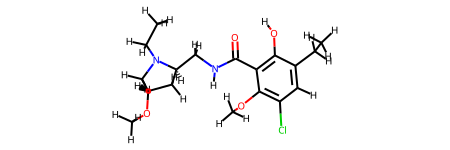

In [20]:
r = Chem.MolFromSmiles('CCC1=CC(Cl)=C(OC)C(C(NC[C@H]2C[C@H](OC)CN2CC)=O)=C1O')
r2=Chem.AddHs(r)
cids =  AllChem.EmbedMolecule(r2)
r2

In [21]:
generate_conformers(r2, n=5)
minimize_multiconf_sdf(r2, 'lal23')

loaded <rdkit.Chem.rdchem.Mol object at 0x7f603d425760> as single 3d mol object
1 unique molecule(s) loaded, with 6 total conformers
lal23 : 6 conformers
Parametrizing lal23 (may take a moment to calculate charges)


Conformer         Initial PE        Minimized PE        RMS between initial and minimized conformer
    1 /     6 :  128.335 kcal/mol   56.984 kcal/mol     0.615 Angstroms
    2 /     6 :  119.040 kcal/mol   56.620 kcal/mol     1.121 Angstroms
    3 /     6 :  131.850 kcal/mol   60.408 kcal/mol     1.622 Angstroms
    4 /     6 :  126.380 kcal/mol   59.147 kcal/mol     0.667 Angstroms
    5 /     6 :  119.345 kcal/mol   59.952 kcal/mol     1.023 Angstroms
    6 /     6 :  124.395 kcal/mol   50.502 kcal/mol     1.255 Angstroms


In [32]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem import PyMol
from rdkit.Chem.Subshape import SubshapeAligner, SubshapeBuilder, SubshapeObjects
mols = [m for m in Chem.SDMolSupplier('lal_ETQ_conf1_minimized.sdf')]
mols2 = [m for m in Chem.SDMolSupplier('/content/lal23_lal23_conf1_minimized.sdf')]
ref = Chem.Mol(mols[0].ToBinary())
probe = Chem.Mol(mols2[0].ToBinary())
AllChem.CanonicalizeConformer(ref.GetConformer())
builder = SubshapeBuilder.SubshapeBuilder()
builder.gridDims = (20.,20.,10)
builder.gridSpacing=0.5
builder.winRad = 4.

In [31]:
refShape = builder.GenerateSubshapeShape(ref)


In [33]:
probeShape = builder.GenerateSubshapeShape(probe)

In [34]:
aligner = SubshapeAligner.SubshapeAligner()

In [35]:
algs = aligner.GetSubshapeAlignments(ref, refShape, probe, probeShape, builder)

RDKit INFO: [14:01:00] INFO: Generating triangle matches
RDKit INFO: [14:01:01] INFO: Got 111007 possible alignments in 1.4 seconds
RDKit INFO: [14:01:01] INFO: Doing direction pruning
RDKit INFO: [14:01:05] INFO: 19648 possible alignments remain. (3.6 seconds required)
RDKit INFO: [14:01:05] INFO: Shape-based Pruning
RDKit INFO: [14:01:06] INFO:   processed 100 of 19648. 19549 alignments remain
RDKit INFO: [14:01:07] INFO:   processed 200 of 19648. 19449 alignments remain
RDKit INFO: [14:01:08] INFO:   processed 300 of 19648. 19349 alignments remain
RDKit INFO: [14:01:09] INFO:   processed 400 of 19648. 19249 alignments remain
RDKit INFO: [14:01:11] INFO:   processed 500 of 19648. 19149 alignments remain
RDKit INFO: [14:01:12] INFO:   processed 600 of 19648. 19049 alignments remain
RDKit INFO: [14:01:13] INFO:   processed 700 of 19648. 18949 alignments remain
RDKit INFO: [14:01:14] INFO:   processed 800 of 19648. 18849 alignments remain
RDKit INFO: [14:01:15] INFO:   processed 900 of 

In [ ]:
from rdkit.Chem.PyMol import MolViewer
v = MolViewer()

We can see that the difference between the active conformer and the lowest energy conformer in a vac is about 1.5 kcal per mol.